## Setup

In [1]:
import pandas as pd
import numpy as np
import ast
import math
import random
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from scipy import stats
import pickle
import dynesty
from dynesty import utils as dyfunc
#from dynesty import plotting as dyplot
import pickle
from scipy.stats import truncexpon
from dynesty import DynamicNestedSampler


# The following is an adaptation of dynesty.plotting customized for this problem
# It has everything as the original library, but the function traceplot has been adapted
# You need to copy the file plotting_customized.py to your dynesty folder. 
# As guidance, in this Ubuntu is at \"~/.local/lib/python3.8/site-packages/dynesty
from dynesty import plotting_customized as dyplot


In [40]:
#from dynesty import plotting_sequi2 as dyplot

#### Function definitions

In [3]:
# copmute invariant masses from a datraframe with the event

Eminbb = 100.0
Eminaa = 120.0
Emaxbb = 140.0
Emaxaa = 130.0

def mbb(df):
    tmp = df[(df['type']==4) & (df['btag']>0)].sort_values(by=['btag'], ascending=False)
    if len(tmp) > 1:        
        pt0 = tmp.iloc[0]['pt']
        pt1 = tmp.iloc[1]['pt']
        eta0 = tmp.iloc[0]['eta']
        eta1 = tmp.iloc[1]['eta']
        phi0 = tmp.iloc[0]['phi']
        phi1 = tmp.iloc[1]['phi']
        mbb = math.sqrt( 2 * pt0 * pt1 * (math.cosh( eta0 - eta1 ) - math.cos( phi0 - phi1 )))
        if mbb > Eminbb and mbb < Emaxbb: 
            return mbb
        else:
            return -1
    else:
        return -1
    

def maa(df):
    tmp = df[df['type']==0].sort_values(by=['pt'], ascending=False)
    if len(tmp) > 1:        
        pt0 = tmp.iloc[0]['pt']
        pt1 = tmp.iloc[1]['pt']
        eta0 = tmp.iloc[0]['eta']
        eta1 = tmp.iloc[1]['eta']
        phi0 = tmp.iloc[0]['phi']
        phi1 = tmp.iloc[1]['phi']
        maa = math.sqrt( 2 * pt0 * pt1 * (math.cosh( eta0 - eta1 ) - math.cos( phi0 - phi1 )))
        if maa > Eminaa and maa < Emaxaa: 
            return maa
        else:
            return -1
    else:
        return -1
    
def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))


def expbb(x,a,l):
    return a * np.exp(-l*(x-Eminbb))
    
def expaa(x,a,l):
    return a * np.exp(-l*(x-Eminaa))
    

In [4]:
with open('lhcdata.pkl', 'rb') as handle:
    lhcdata = pickle.load(handle)

signal_events = lhcdata['signal']
background_events = lhcdata['background']

In [5]:
len(signal_events), len(background_events)

(7081, 3115)

## Fit curves to pseudo-data

#### signal: Normals for bb and $\gamma\gamma$

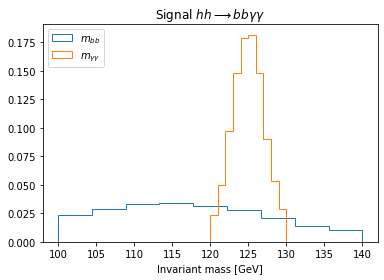

In [6]:
# extract the histogram data in order to fit the corresponding Normal distributions in hte next steps
signal_bb, bins_bb, bars = plt.hist([x[0] for x in signal_events],density=1, histtype='step', bins=np.linspace(100,140,10), label='$m_{bb}$')
signal_aa, bins_aa, bars = plt.hist([x[1] for x in signal_events],density=1, histtype='step', bins=np.linspace(115,135,21), label='$m_{\gamma\gamma}$')
plt.title('Signal $hh \longrightarrow bb \gamma\gamma$')
plt.xlabel('Invariant mass [GeV]')
plt.legend()
plt.show()

In [7]:
# Define the x-values as the mid-points in the histogram bins
xs_bb=[]
for i in range(len(bins_bb)-1):
    xs_bb.append((bins_bb[i]+bins_bb[i+1])/2)
xs_aa=[]
for i in range(len(bins_aa)-1):
    xs_aa.append((bins_aa[i]+bins_aa[i+1])/2)

In [8]:
# Do the fits
popt_bb,pcov_bb = curve_fit(gaus,xs_bb,signal_bb,p0=[10,110,30])
popt_aa,pcov_aa = curve_fit(gaus,xs_aa,signal_aa,p0=[10,110,30])

In [9]:
popt_bb = abs(popt_bb)
popt_aa = abs(popt_aa)

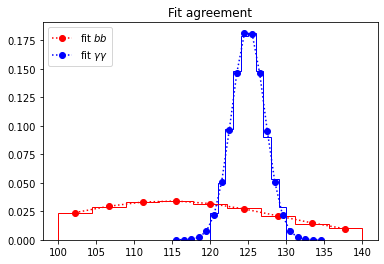

In [11]:
#plt.plot(x,y,'b+:',label='data')
plt.plot(xs_bb,gaus(xs_bb,*popt_bb),'ro:',label='fit $bb$')
plt.plot(xs_aa,gaus(xs_aa,*popt_aa),'bo:',label='fit $\gamma\gamma$')
plt.hist([x[0] for x in signal_events],density=1, histtype='step', color='red', bins=np.linspace(100,140,10))
plt.hist([x[1] for x in signal_events],density=1, histtype='step', color='blue', bins=np.linspace(115,135,21))
plt.legend()
plt.title('Fit agreement')
plt.show()

In [12]:
plt.rcParams['text.usetex'] = False

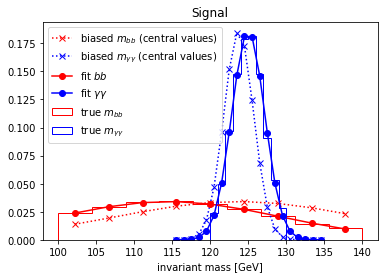

In [13]:
# zx1
#popt_bb_biased=[popt_bb[0],popt_bb[1]*1.08,popt_bb[2]*1.1] 
#popt_aa_biased=[popt_aa[0],popt_aa[1]*.97,popt_aa[2]*0.9]

popt_bb_biased=[popt_bb[0],popt_bb[1]*1.08,popt_bb[2]*1.1] # zx1
popt_aa_biased=[popt_aa[0],popt_aa[1]*0.99,popt_aa[2]*0.9] # zx1

#plt.plot(x,y,'b+:',label='data')
plt.plot(xs_bb,gaus(xs_bb,*popt_bb_biased),'rx:',label='biased $m_{bb}$ (central values)')
plt.plot(xs_aa,gaus(xs_aa,*popt_aa_biased),'bx:',label='biased $m_{\gamma\gamma}$ (central values)')
plt.plot(xs_bb,gaus(xs_bb,*popt_bb),'ro-',label='fit $bb$')
plt.plot(xs_aa,gaus(xs_aa,*popt_aa),'bo-',label='fit $\gamma\gamma$')
plt.hist([x[0] for x in signal_events],density=1, histtype='step', color='red', bins=np.linspace(100,140,10), label='true $m_{bb}$')
plt.hist([x[1] for x in signal_events],density=1, histtype='step', color='blue', bins=np.linspace(115,135,21), label ='true $m_{\gamma\gamma}$')
plt.xlabel('invariant mass [GeV]')
plt.legend()
plt.title("Signal")
plt.savefig('signal.png')
plt.show()

#### background: Exponential for bb and $\gamma\gamma$

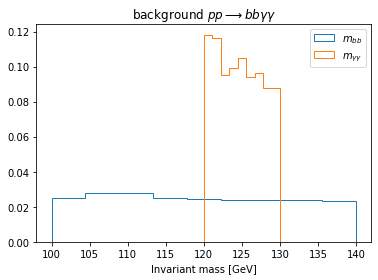

In [14]:
# extract the histogram data in order to fit the corresponding Normal distributions in the next steps
background_bb, bins_bb, bars = plt.hist([x[0] for x in background_events],density=1, histtype='step', bins=np.linspace(Eminbb,Emaxbb,10), label='$m_{bb}$')
background_aa, bins_aa, bars = plt.hist([x[1] for x in background_events],density=1, histtype='step', bins=np.linspace(Eminaa,Emaxaa,10), label='$m_{\gamma\gamma}$')
plt.title('background $pp \longrightarrow bb \gamma\gamma$')
plt.xlabel('Invariant mass [GeV]')
plt.legend()
plt.show()

In [15]:
# Define the x-values as the mid-points in the histogram bins
xs_bb=[]
for i in range(len(bins_bb)-1):
    xs_bb.append((bins_bb[i]+bins_bb[i+1])/2)
xs_aa=[]
for i in range(len(bins_aa)-1):
    xs_aa.append((bins_aa[i]+bins_aa[i+1])/2)
xs_bb = np.array(xs_bb)
xs_aa = np.array(xs_aa)

In [16]:
# Do the fits
popt_bb_background,pcov_bb_background = curve_fit(expbb,xs_bb,background_bb)
popt_aa_background,pcov_aa_background = curve_fit(expaa,xs_aa,background_aa)

In [17]:
print(popt_bb_background)
print(popt_aa_background)

[0.02698145 0.00386256]
[0.11674152 0.03180101]


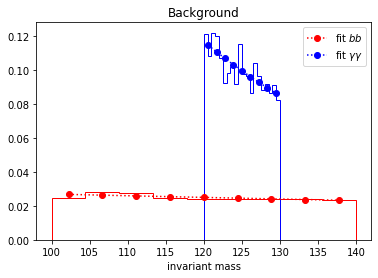

In [18]:
#plt.plot(x,y,'b+:',label='data')
plt.plot(np.array(xs_bb),expbb(np.array(xs_bb),*popt_bb_background),'ro:',label='fit $bb$')
plt.plot(np.array(xs_aa),expaa(np.array(xs_aa),*popt_aa_background),'bo:',label='fit $\gamma\gamma$')
plt.hist([x[0] for x in background_events],density=1, histtype='step', color='red', bins=np.linspace(100,140,10))
plt.hist([x[1] for x in background_events],density=1, histtype='step', color='blue', bins=np.linspace(Eminaa,Emaxaa,21))
plt.xlabel('invariant mass')
plt.title('Background')
plt.legend()
plt.show()

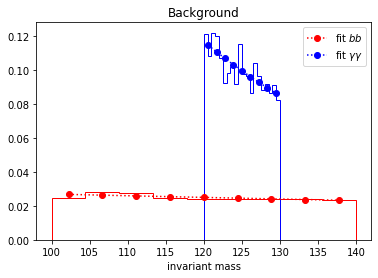

In [19]:
#plt.plot(x,y,'b+:',label='data')
plt.plot(np.array(xs_bb),expbb(np.array(xs_bb),*popt_bb_background),'ro:',label='fit $bb$')
plt.plot(np.array(xs_aa),expaa(np.array(xs_aa),*popt_aa_background),'bo:',label='fit $\gamma\gamma$')
plt.hist([x[0] for x in background_events],density=1, histtype='step', color='red', bins=np.linspace(100,140,10))
plt.hist([x[1] for x in background_events],density=1, histtype='step', color='blue', bins=np.linspace(Eminaa,Emaxaa,21))
plt.xlabel('invariant mass')
plt.title('Background')
plt.legend()
plt.show()

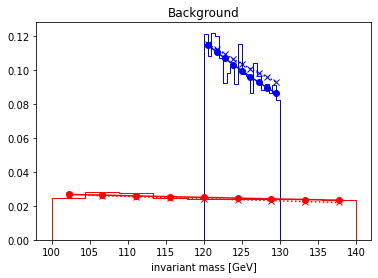

In [20]:
popt_bb_background_biased=[popt_bb_background[0],popt_bb_background[1]*1.4]
popt_aa_background_biased=[popt_aa_background[0],popt_aa_background[1]*0.75]
#plt.plot(x,y,'b+:',label='data')
plt.plot(xs_bb,expbb(np.array(xs_bb),*popt_bb_background_biased),'rx:',label='biased $bb$')
plt.plot(xs_aa,expaa(np.array(xs_aa),*popt_aa_background_biased),'bx:',label='biased $\gamma\gamma$')
plt.plot(xs_bb,expbb(np.array(xs_bb),*popt_bb_background),'ro-',label='true $bb$')
plt.plot(xs_aa,expaa(np.array(xs_aa),*popt_aa_background),'bo-',label='true $\gamma\gamma$')
plt.hist([x[0] for x in background_events],density=1, histtype='step', color='red', bins=np.linspace(100,140,10))
plt.hist([x[1] for x in background_events],density=1, histtype='step', color='blue', bins=np.linspace(Eminaa,Emaxaa,21))
plt.title('Background')
plt.xlabel('invariant mass [GeV]')
plt.savefig('background.png')
#plt.legend()
plt.show()

## Create pseudo-data

determine luminosity and signal fraction

In [21]:
def create_data(N, pi_signal):
    Ns = int(N*pi_signal)
    Nb = int(N*(1-pi_signal))
    print(Ns,Nb)
    signal = random.sample(signal_events, Ns)
    signal = [x + [1] for x in signal]
    background = random.sample(background_events, Nb)
    background = [x + [0] for x in background]
    data = signal + background
    random.shuffle(data)    
    return data

325 2925


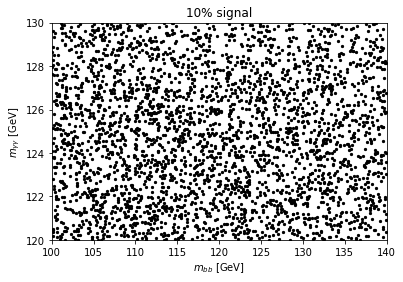

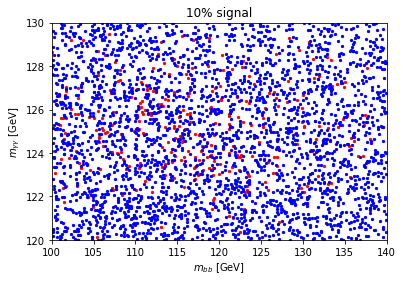

In [23]:
pi_s_true = 0.1
neff = 10000
lendata = 3250
myrun = 'large_'+str(lendata)+'_events'
X = create_data(lendata,pi_s_true)
plt.scatter([x[0] for x in X],[x[1] for x in X],c = 'black',s=5)
plt.xlim(Eminbb,Emaxbb)
plt.ylim(Eminaa,Emaxaa)
plt.xlabel('$m_{bb}$ [GeV]')
plt.ylabel('$m_{\gamma\gamma}$ [GeV]')
plt.title(str(int(pi_s_true*100))+'% signal')
plt.savefig('/home/sequi/Documents/dihiggs/'+myrun+'_unlabeled.png')
plt.show()
plt.scatter([x[0] for x in X if x[2] == 1],[x[1] for x in X if x[2] == 1], s=5, c='red', label='signal')
plt.scatter([x[0] for x in X if x[2] == 0],[x[1] for x in X if x[2] == 0], s=5, c='blue', label='background')
plt.xlim(Eminbb,Emaxbb)
plt.ylim(Eminaa,Emaxaa)
plt.xlabel('$m_{bb}$ [GeV]')
plt.ylabel('$m_{\gamma\gamma}$ [GeV]')
plt.title(str(int(pi_s_true*100))+'% signal')
plt.savefig('/home/sequi/Documents/dihiggs/'+myrun+'_labeled.png')
#plt.legend()
plt.show()

## Dynesty

#### Setup Dynesty

In [24]:
# t is the variables that contains the parameters of the likelihood, t = theta
# t = [muhbb, sigmahbb, muhaa, sigmahaa,  lb, lA, pi_S]
#
def psignaln(x,t,n):
    #return  stats.norm.pdf(x[n][0],t[0], t[1]) * stats.norm.pdf(x[n][1],t[0], t[1])
    return stats.truncnorm.pdf(x[n][0], (Eminbb-t[0])/t[1],(Emaxbb-t[0])/t[1], loc=t[0], scale=t[1]) * stats.truncnorm.pdf(x[n][1], (Eminaa-t[2])/t[3],(Emaxaa-t[2])/t[3], loc=t[2], scale=t[3])

def pbackgroundn(x,t,n):
    return ( t[4] * np.exp(- t[4] * (x[n][0] - Eminbb) ) / (1 - np.exp(- t[4] * (Emaxbb - Eminbb))) ) * ( t[5] * np.exp(- t[5] * (x[n][1] - Eminaa) ) / (1 - np.exp(- t[5] * (Emaxaa - Eminaa))) )
    
def pn(x,t,n):
    return ( 1 - t[6] ) * pbackgroundn(x,t,n) + ( t[6] ) * psignaln(x,t,n)

def lnp(x,t):
    return sum ( [ np.log(pn(x,t,n)) for n in range(len(x)) ] )

# This is a function of just t.  X should be a global variable (list) containing in each element
# the [mbb, maa] of event.
def loglike(t):
    return lnp(X,t)

#### Prior: it should be biased from the true value

In [26]:
# use this one
alpha = 1
beta = 1
# Define our uniform prior.
def ptform(u):
    x = np.array(u)  # copy u
    x[0] = stats.norm.ppf(u[0], popt_bb_biased[1], popt_bb_biased[1]*0.15) # Mean for mbb center: A Normal with its center biased and a deviation equal to 5% of the mean
    x[1] = stats.norm.ppf(u[1], popt_bb_biased[2], popt_bb_biased[2]*0.15) # Sigma or mbb
    x[2] = stats.norm.ppf(u[2], popt_aa_biased[1], popt_aa_biased[1]*0.10) # Mean for mAA
    x[3] = stats.norm.ppf(u[3], popt_aa_biased[2], popt_aa_biased[2]*0.15) # Sigma for mAA   
    x[4] = stats.norm.ppf(u[4], popt_bb_background_biased[1], popt_bb_background_biased[1]*0.40) # lambda for bb
    x[5] = stats.norm.ppf(u[5], popt_aa_background_biased[1], popt_aa_background_biased[1]*0.40) # lambda for AA    
    x[6] = stats.beta.ppf(u[6], alpha, beta) # signal fraction
#    x[6] = 1 - u[6]
    return x
ndim = 7

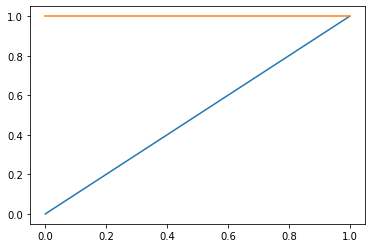

In [27]:
plt.plot(np.linspace(0,1,100),[stats.beta.ppf(x,alpha, beta) for x in np.linspace(0,1,100)])
plt.plot(np.linspace(0,1,100),[stats.beta.pdf(x,alpha, beta) for x in np.linspace(0,1,100)])
plt.show()

### Sampling

In [ ]:
%%time
dsampler = DynamicNestedSampler(loglike, ptform, ndim)
dsampler.run_nested(dlogz_init=0.1, nlive_init=1000, maxiter_init=5000, nlive_batch=150,n_effective=neff, maxbatch=250)

In [43]:
xtrue = [popt_bb[1], popt_bb[2], popt_aa[1], popt_aa[2], popt_bb_background[1], popt_aa_background[1], pi_s_true]
xtrue_biased = [popt_bb_biased[1], popt_bb_biased[2], popt_aa_biased[1], popt_aa_biased[2], popt_bb_background_biased[1], popt_aa_background_biased[1], pi_s_true]

In [45]:
results = dsampler.results

In [49]:
myresults = {'X': X, 'xtrue': xtrue, 'xtrue_biased': xtrue_biased}

In [29]:
myrun

'large_3250_events'

In [51]:
# Dump the data
with open(myrun+'_results.pkl', 'wb') as f:
    pickle.dump(results, f)    
with open(myrun+'_my_results.pkl', 'wb') as f:
    pickle.dump(myresults, f)

In [37]:
# Read the data
with open(myrun+'_results.pkl', 'rb') as f:
    results = pickle.load(f)
with open(myrun+'_my_results.pkl', 'rb') as f:
    myresults = pickle.load(f)

### Plotting

In [41]:
myresults['xtrue']

[114.55192220315759,
 14.579218540060001,
 124.98765788830707,
 2.2481061431735427,
 0.0038625609915369868,
 0.03180100734202741,
 0.1]

In [42]:
means = [[myresults['xtrue_biased'][0],0.15*myresults['xtrue_biased'][0]], 
         [myresults['xtrue_biased'][1],0.15*myresults['xtrue_biased'][1]], 
         [myresults['xtrue_biased'][2],0.10*myresults['xtrue_biased'][2]], 
         [myresults['xtrue_biased'][3],0.15*myresults['xtrue_biased'][3]], 
         [myresults['xtrue_biased'][4],0.40*myresults['xtrue_biased'][4]], 
         [myresults['xtrue_biased'][5],0.40*myresults['xtrue_biased'][5]], 
         [0.5,0.5]]

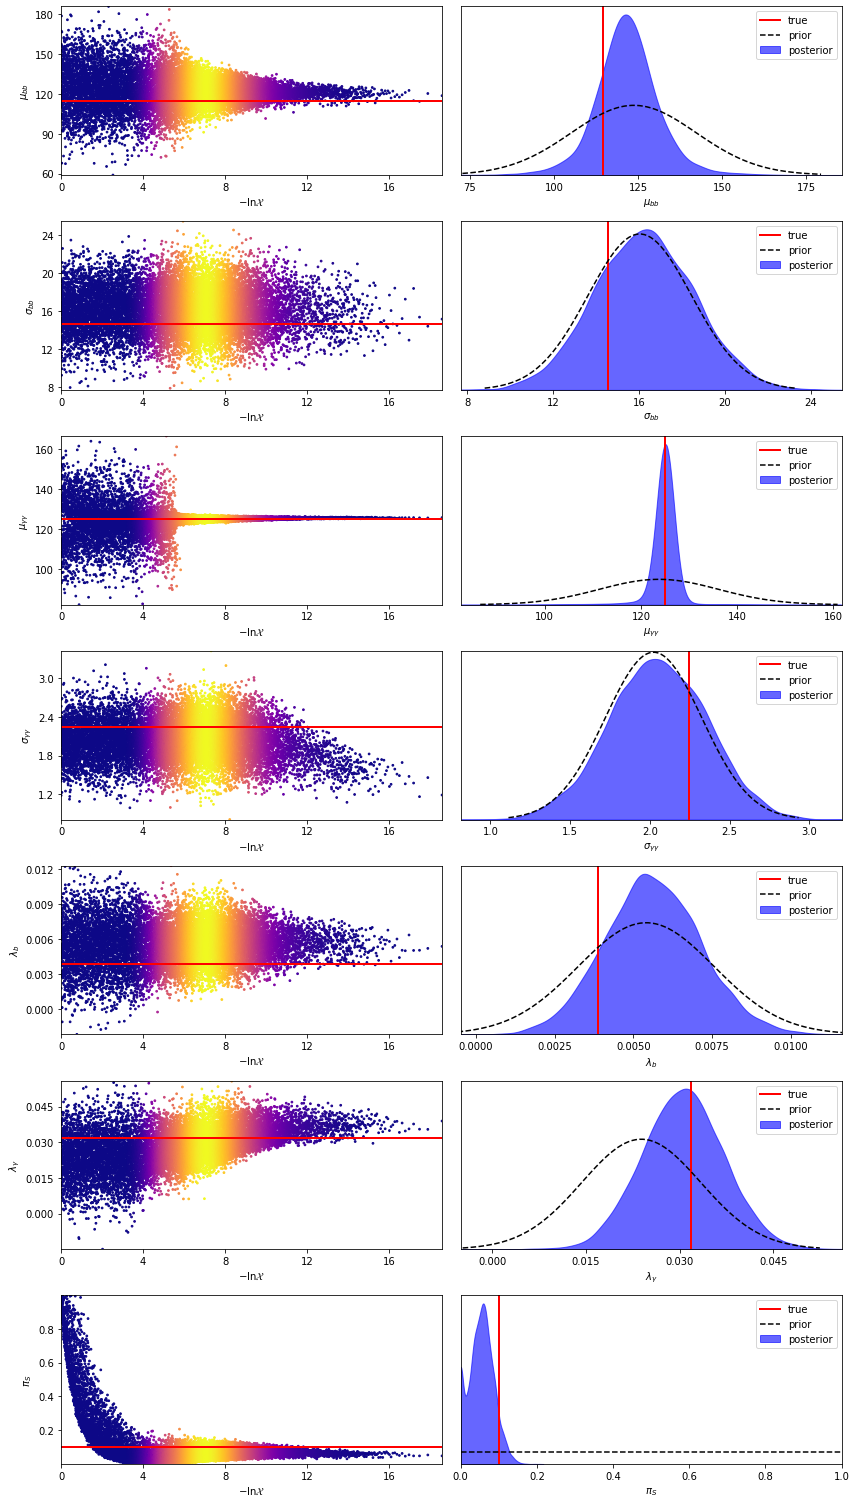

In [43]:
tfig2, taxes2 = dyplot.traceplot(results, post_color='blue', truths=myresults['xtrue'], means= means, quantiles=None, labels=['$\mu_{bb}$','$\sigma_{bb}$','$\mu_{\gamma\gamma}$','$\sigma_{\gamma\gamma}$','$\lambda_b$','$\lambda_\gamma$', '$\pi_S$'])

In [46]:
tfig2.savefig(myrun+'_full_run.png')

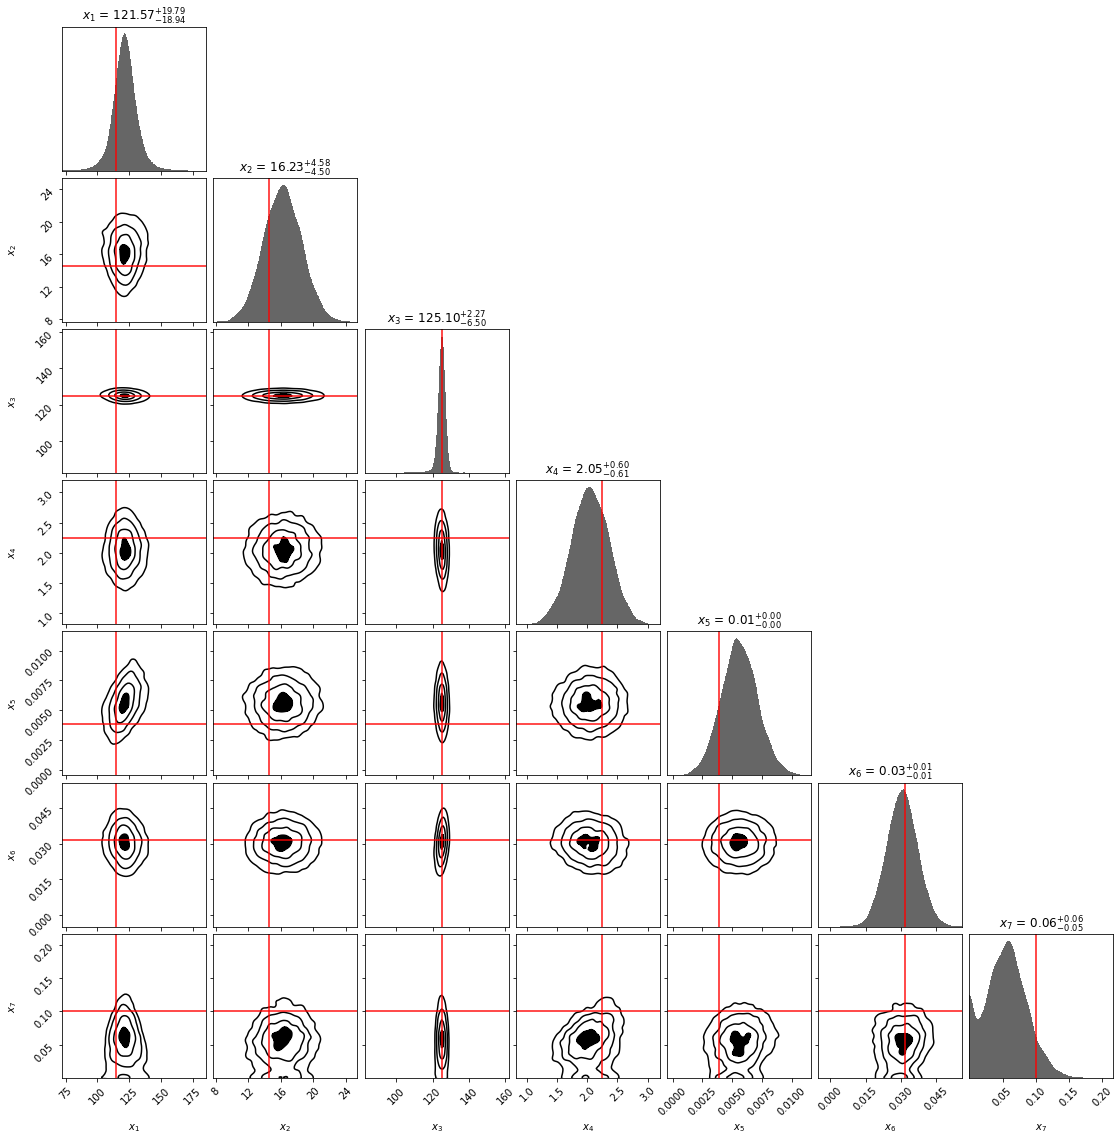

In [45]:
fg, ax = dyplot.cornerplot(results, color='black', truths=myresults['xtrue'],
                           #span=[(-4.5, 4.5) for i in range(ndim)],
                           show_titles=True, quantiles=None)

In [47]:
fg.savefig(myrun+'_corner-plot.png')